## Initalize the model and then load weight

In [1]:
import torch
import torch.nn as nn
from torchvision.ops import deform_conv2d

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, use_dcn=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        if use_dcn:
            self.conv2 = deform_conv2d
        else:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = None

        if stride != 1 or in_channels != out_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        out = self.relu(out)

        return out


class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, use_dcn=False):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        if use_dcn:
            self.conv2 = deform_conv2d
        else:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = None

        if stride != 1 or in_channels != out_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        return x1, x2, x3, x4


def resnet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def resnet50():
    return ResNet(BottleneckBlock, [3, 4, 6, 3])


def resnet101():
    return ResNet(BottleneckBlock, [3, 4, 23, 3])


def resnet152():
    return ResNet(BottleneckBlock, [3, 8, 36, 3])

In [2]:
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, input_channels, k=50, adaptive=True, serial=False, bias=False):
        super(Decoder, self).__init__()
        self.k = k
        self.adaptive = adaptive
        self.serial = serial

        self.conv = nn.ModuleList([nn.Conv2d(in_ch, 256, kernel_size=1, bias=bias) for in_ch in input_channels])

        self.up5 = nn.Upsample(scale_factor=2, mode='nearest')
        self.up4 = nn.Upsample(scale_factor=2, mode='nearest')
        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')

        self.out5 = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=3, padding=1, bias=bias),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=8, mode='nearest')
        )
        self.out4 = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=3, padding=1, bias=bias),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=4, mode='nearest')
        )
        self.out3 = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=3, padding=1, bias=bias),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest')
        )
        self.out2 = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=3, padding=1, bias=bias),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.probability_map = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=3, padding=1, bias=bias),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, bias=bias),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2, bias=bias),
            nn.Sigmoid()
        )

        if self.adaptive:
            in_thresh_channels = 256
            if self.serial:
                in_thresh_channels += 1
            self.threshold_map = nn.Sequential(
                nn.Conv2d(in_thresh_channels, 64, kernel_size=3, padding=1, bias=bias),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, bias=bias),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2, bias=bias),
                nn.Sigmoid()
            )

        self.apply(self.weights_init)
        if self.adaptive:
            self.threshold_map.apply(self.weights_init)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.kaiming_normal_(m.weight.data)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
        elif classname.find('BatchNorm') != -1:
            if hasattr(m, 'weight') and m.weight is not None:
                nn.init.constant_(m.weight.data, 1)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 1e-4)

    def approximate_binary_map(self, x, y):
        return torch.sigmoid(self.k * (x - y))

    def step_function(self, probability_map, threshold_map):
        return (probability_map > threshold_map).float()

    def forward(self, inputs, training_mode):
        '''
        inputs:
            (N, 64, H/4, W/4)
            (N, 128, H/8, W/8)
            (N, 256, H/16, W/16)
            (N, 512, H/32, W/32)

        outputs:
            training:
                adaptive=True:
                    probability_map: (N, 1, H, W)
                    threshold_map: (N, 1, H, W)
                    binary_map: (N, 1, H, W)
                adaptive=False:
                    probability_map: (N, 1, H, W)
            inference:
                adaptive=True:
                    probability_map: (N, 1, H, W)
                    binary_map: (N, 1, H, W)
                adaptive=False:
                    probability_map: (N, 1, H, W)
                    binary_map: (N, 1, H, W)
        '''

        in2 = self.conv[0](inputs[0]) # (N, 256, H/4, W/4)
        in3 = self.conv[1](inputs[1]) # (N, 256, H/8, W/8)
        in4 = self.conv[2](inputs[2]) # (N, 256, H/16, W/16)
        in5 = self.conv[3](inputs[3]) # (N, 256, H/32, W/32)

        out4 = self.up5(in5) + in4 # (N, 256, H/16, W/16)
        out3 = self.up4(out4) + in3 # (N, 256, H/8, W/8)
        out2 = self.up3(out3) + in2 # (N, 256, H/4, W/4)

        p5 = self.out5(in5) # (N, 64, H, W)
        p4 = self.out4(out4) # (N, 64, H, W)
        p3 = self.out3(out3) # (N, 64, H, W)
        p2 = self.out2(out2) # (N, 64, H, W)

        fuse = torch.cat([p5, p4, p3, p2], dim=1) # (N, 256, H, W)
        probability_map = self.probability_map(fuse) # (N, 1, H, W)

        if training_mode:
            if self.adaptive:
                if self.serial:
                    fuse = torch.cat((fuse, F.interpolate(probability_map, size=fuse.shape[2:], mode='nearest')), dim=1)
                threshold_map = self.threshold_map(fuse) # (N, 1, H, W)
                binary_map = self.approximate_binary_map(probability_map, threshold_map) # (N, 1, H, W)
                return OrderedDict({
                    "probability_map": probability_map,
                    "threshold_map": threshold_map,
                    "binary_map": binary_map
                })
            else:
                return OrderedDict({
                    "probability_map": probability_map,
                })
        else:
            binary_map = (probability_map > 0.2).float()

            return OrderedDict({
                "probability_map": probability_map,
                "binary_map": binary_map
            })

In [3]:
class DBNet(nn.Module):
    def __init__(self, backbone, input_channels, k, adaptive, serial, bias):
        super(DBNet, self).__init__()

        # initalize backbone
        if backbone == "resnet18":
            self.backbone = resnet18()
        elif backbone == "resnet34":
            self.backbone = resnet34()
        elif backbone == "resnet50":
            self.backbone = resnet50()
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")

        # initalize the decoder
        self.decoder = Decoder(input_channels=input_channels, k=k, adaptive=adaptive, serial=serial, bias=bias)

    def forward(self, x, training_mode):
        features = self.backbone(x) # returns x1, x2, x3, x4
        outputs = self.decoder(features, training_mode)
        return outputs

In [4]:
model = DBNet(backbone="resnet50", input_channels=[256, 512, 1024, 2048], k=50, adaptive=True, serial=True, bias=False)

In [5]:
import sys
def calculate_loss(*args, **kwargs):
    raise NotImplementedError("calculate_loss is a placeholder and should not be called during loading")

sys.modules['scripts.train'] = sys.modules[__name__]

checkpoint_path = "/content/epoch_0_step_37760_loss0.1557.pth"
checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)

model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

## Inference

In [7]:
import cv2
import numpy as np
import torch
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt

def resize_preserving_aspect_32(img, target_short_side=736):
    """
    Resizes `img` so that its short side is `target_short_side`,
    preserving aspect ratio, THEN rounds the final width/height
    to multiples of 32 to avoid dimension mismatch in FPN-like structures.
    """
    h, w = img.shape[:2]

    # 1 Compute new_h, new_w for "short side = target_short_side"
    if h < w:
        scale = target_short_side / float(h)
        new_h = target_short_side
        new_w = int(round(w * scale))
    else:
        scale = target_short_side / float(w)
        new_w = target_short_side
        new_h = int(round(h * scale))

    # 2 Round them to multiples of 32
    def _round_to_32(x):
        return int(round(x / 32.0) * 32)

    new_h_32 = _round_to_32(new_h)
    new_w_32 = _round_to_32(new_w)

    # 3 Resize
    resized = cv2.resize(img, (new_w_32, new_h_32), interpolation=cv2.INTER_LINEAR)

    scale_w = new_w_32 / float(w)
    scale_h = new_h_32 / float(h)

    return resized, scale_w, scale_h

def probability_to_binary(prob_map, thresh=0.2):
    bin_map = (prob_map >= thresh).astype(np.uint8)
    return bin_map

def find_connected_components(bin_map):
    contours, hierarchy = cv2.findContours(
        bin_map, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    )
    return contours

def expand_polygon(contour, r=1.5):
    poly = Polygon(contour.squeeze())
    if poly.area < 1.0:
        return None
    A_prime = poly.area
    L_prime = poly.length
    D_prime = (A_prime * r) / (L_prime + 1e-5)
    expanded = poly.buffer(D_prime)
    return expanded

def polygon_to_array(shapely_poly):
    if shapely_poly is None or shapely_poly.is_empty:
        return None
    exterior_coords = shapely_poly.exterior.coords
    return np.array(exterior_coords, dtype=np.float32)

def run_inference(
    image_path,
    model,
    target_short_side=736,
    prob_thresh=0.2,
    dilation_ratio=1.5,
    device='cuda'
):
    orig = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if orig is None:
        raise ValueError(f"Could not read image from {image_path}")
    orig_h, orig_w = orig.shape[:2]

    resized, scale_w, scale_h = resize_preserving_aspect_32(orig, target_short_side)
    new_h, new_w = resized.shape[:2]

    inp = resized[:, :, ::-1].astype(np.float32) / 255.0
    inp_t = torch.from_numpy(inp.transpose(2,0,1)).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(inp_t, True)
        prob_map_tensor = outputs["probability_map"]  # (1,1,H',W')
    prob_map = prob_map_tensor.squeeze().cpu().numpy()  # (H',W')

    bin_map = probability_to_binary(prob_map, thresh=prob_thresh)
    contours = find_connected_components(bin_map)

    expanded_polygons = []
    for c in contours:
        if len(c) < 3:
            continue
        poly_expanded = expand_polygon(c, r=dilation_ratio)
        if poly_expanded is None or poly_expanded.is_empty:
            continue
        expanded_polygons.append(poly_expanded)

    final_contours = []
    for poly in expanded_polygons:
        arr = polygon_to_array(poly)
        if arr is None:
            continue
        arr[:,0] /= scale_w
        arr[:,1] /= scale_h
        final_contours.append(arr)

    return final_contours, orig

def visualize_contours(original_img, contours):
    viz = original_img.copy()
    for pts in contours:
        pts_int = pts.round().astype(np.int32)
        cv2.polylines(viz, [pts_int], True, (0,255,0), 2)
    return viz

def main_inference_demo(image_path, model, target_short_side=736):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()

    final_polygons, orig_image = run_inference(
        image_path,
        model,
        target_short_side=target_short_side,
        prob_thresh=0.2,
        dilation_ratio=1.5,
        device=device
    )

    vis_img = visualize_contours(orig_image, final_polygons)

    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.title(f"DB Text Detection (short side={target_short_side})")
    plt.axis("off")
    plt.show()

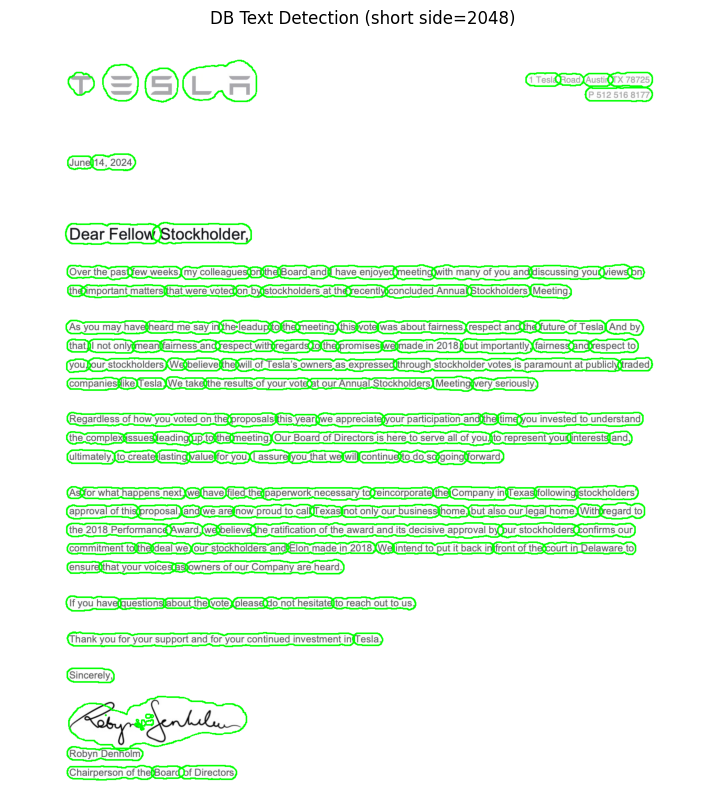

In [9]:
main_inference_demo("/content/dbnet_inference_test1.jpeg", model, 2048)

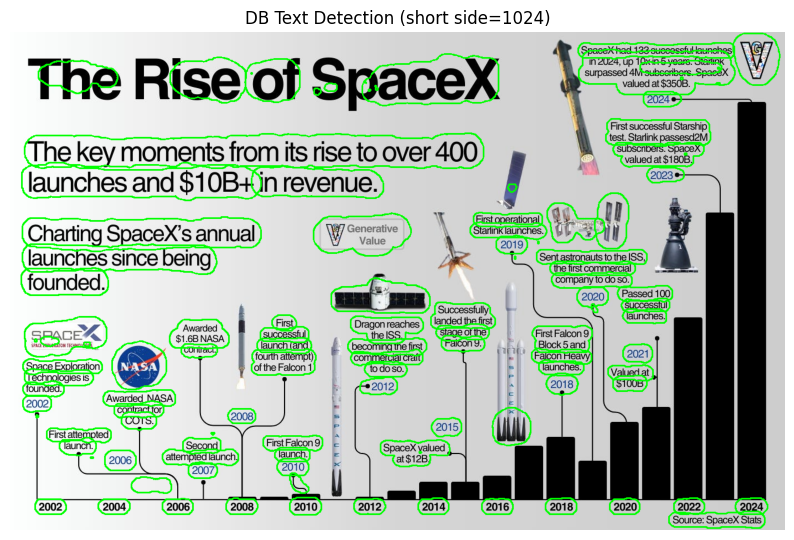

In [20]:
main_inference_demo("/content/dbnet test2.jpg", model, 1024)